<a href="https://colab.research.google.com/github/junieberry/DL-fromScratch2/blob/main/06_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cd /content/drive/MyDrive/밑시딥/deep-learning-from-scratch-2

/content/drive/MyDrive/밑시딥/deep-learning-from-scratch-2


In [ ]:
import sys
sys.path.append('..')
from common.util import preprocess
import numpy as np

## LSTM

In [ ]:
from common.functions import sigmoid

class LSTM:

  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    # forward 때 저장했다가 backward에 사용
    self.cache = None

  def forward(self, x, h_prev, c_prev):
    Wx, Wh, b = self.params
    N, H = h_prev.shape

    # Affine 변환
    A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b

    # slice
    f = sigmoid(A[:, :H])
    g = tanh(A[:, H:2*H])
    i = sigmoid(A[:, 2*H:3*H])
    o = sigmoid(A[:, 3*H:])

    c_next = f * c_prev + g * i
    h_next = o * np.tanh(c_next)

    self.cache = (x. h_prev, c_prev, i, f, g, o, c_next)
    return h_next, c_next

## Time LSTM

In [ ]:
class TimeLSTM:
  def __init__(self, Wx, Wh, b, stateful=False):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeors_like(Wh), np.zeros_like(b)]
    self.layers = None
    self.h, self.c = None, None
    self.stateful = stateful

  def forward(self, xs):

    Wx, Wh, b = self.params
    N, T, D = xs.shape
    H = Wh.shape[0]

    self.layers = []
    hs = np.empty((N, T, H), dtype='f')

    if not self.stateful or self.h is None:
      self.h = np.zeros((N,H), dtype='f')
    if not self.stateful or self.c is None:
      self.c = np.zeros((N, H), dtype='f')
    
    for t in range(T):
      layer = LSTM(*self.params)
      self.h, self.c = layer.forward(xs[:,t,:], self.h, self.c)
      hs[:,t,:] = self.h

      self.layers.append(layer)

    return hs

  def backward(self, dhs):
    Wx, Wh, b = self.params
    N, T, H = dhs.shape
    D = Wx.shape[0]

    dxs = np.empty((N, T, D),dtype='f')
    dh, dc = 0,0

    grads = [0, 0, 0]
    for t in reversed(range(T)):
      layer = self.layers[t]
      dx, dh, dc = layer.backward(dhs[:,t,:] + dh, dc)
      dxs[:,t,:] = dx
      for i, grad in enumerate(layer.grads):
        grads[i] += grad
    
    for i,grad in enumerate(grads):
      self.grads[i][...] = grad
      self.dh = dh
      return dxs
  
  def set_state(self, h, c=None):
    self.h, self.c = h,c
  
  def reset_state(self):
    self.h, self.c = None, None

## Rnnlm

In [ ]:
from common.time_layers import *
import pickle

class Rnnlm:
  def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    # initialize weight
    embed_W = (rn(V, D)/100).astype('f')
    lstm_Wx = (rn(D, 4*H)/np.sqrt(D)).astype('f')
    lstm_Wh = (rn(H, 4*H)/np.sqrt(H)).astype('f')
    lstm_b = np.zeros(4*H).astype('f')
    affine_W = (rn(H,V)/np.sqrt(H)).astype('f')
    affine_b = np.zeros(V).astype('f')

    # 계층 생성
    self.layers = [
                   TimeEmbedding(embed_W),
                   TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
                   TimeAffine(affine_W, affine_b)
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.lstm_layer = self.layers[1]

    self.params, self.grads = [],[]
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads
  
  def predict(self, xs):
    for layer in self.layers:
      xs = layer.forward(xs)
    return xs
  
  def forward(self, xs, ts):
    score = self.predict(xs)
    loss = self.loss_layer.forward(score, ts)
    return loss
  
  def backward(self,dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout

  def reset_state(self):
    self.lstm_layer.reset_state()
  
  def save_params(self, file_name='Rnnlm.pkl'):
    with open(file_name, 'wb') as f:
      pickle.dump(self.params, f)
  
  def load_params(self, file_name = 'Rnnlm.pkl'):
    with open(file_name, 'rb') as f:
      self.params = pickle.load(f)

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 10000.54
| 에폭 1 |  반복 21 / 1327 | 시간 7[s] | 퍼플렉서티 2938.96
| 에폭 1 |  반복 41 / 1327 | 시간 15[s] | 퍼플렉서티 1271.66
| 에폭 1 |  반복 61 / 1327 | 시간 23[s] | 퍼플렉서티 968.81
| 에폭 1 |  반복 81 / 1327 | 시간 30[s] | 퍼플렉서티 799.52
| 에폭 1 |  반복 101 / 1327 | 시간 36[s] | 퍼플렉서티 639.50
| 에폭 1 |  반복 121 / 1327 | 시간 43[s] | 퍼플렉서티 643.18
| 에폭 1 |  반복 141 / 1327 | 시간 50[s] | 퍼플렉서티 598.69
| 에폭 1 |  반복 161 / 1327 | 시간 57[s] | 퍼플렉서티 597.36
| 에폭 1 |  반복 181 / 1327 | 시간 64[s] | 퍼플렉서티 582.51
| 에폭 1 |  반복 201 / 1327 | 시간 71[s] | 퍼플렉서티 501.06
| 에폭 1 |  반복 221 / 1327 | 시간 78[s] | 퍼플렉서티 485.94
| 에폭 1 |  반복 241 / 1327 | 시간 85[s] | 퍼플렉서티 437.96
| 에폭 1 |  반복 261 / 1327 | 시간 93[s] | 퍼플렉서티 456.98
| 에폭 1 |  반복 281 / 1327 | 시간 101[s] | 퍼플렉서티 434.51
| 에폭 1 |  반복 301 / 1327 | 시간 108[s] | 퍼플렉서티 399.24
| 에폭 1 |  반복 321 / 1327 | 시간 116[s] | 퍼플렉서티 347.88
| 에폭 1 |  반복 341 / 1327 | 시간 123[s] | 퍼플렉서티 410.30
| 에폭 1 |  반복 361 / 1327 | 시간 132[s] | 퍼플렉서티 409.69
| 에폭 1 |  반복 381 / 1327 | 시간 140[s] | 퍼플렉서티 334.9

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47113 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_

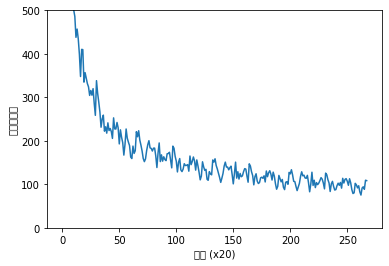

퍼플렉서티 평가 중 ...
234 / 235


NameError: ignored

In [ ]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb

batch_size = 20
wordvec_size = 100
hidden_size = 100
time_size = 35
lr = 20.0
max_epoch = 4
max_grad = 0.25

## 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ =ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

## 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

##기울기 클리핑까지
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

model.reset_state()
ppl.test = eval_perplexity(model, corpus_test)

model.save_params()